# KM analysis

## K-means clustering theory

In this notebook, a weather typing clasification is performed using the commonly known K-Means algorithm. With this clustering technique we are able to group the sea-level-pressure data into different related groups, and then associate a storm-surge situation to each of them... All the python code is hosted at `sscode/kma.py`, where we use the scikit-learn package available [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

Regarding the maths... a description of the algorithm can be found at [wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)!! But lets briefly explain the algorithm here:

The KMA clustering technique divides the high-dimensional data space into a number of clusters, each one deﬁned by a prototype and formed by the data for which the prototype is the nearest. Given a database of n-dimensional vectors $X = {x_1, x_2, ..., x_N}$, where $N$ is the total amount of data and $n$ is the dimension of each data $x_k = {x_{1k}, ..., x_{nk}}$, KMA is applied to obtain M groups deﬁned by a prototype or centroid $v_k = {v_{1k}, ..., v_{nk}}$ of the same dimension of the original
data, being $k = 1, ..., M$. The classiﬁcation procedure starts with a random initialization of the centroids ${v_1^0, v_2^0, ..., v_M^0}$. On each iteration $r$, the nearest data to each centroid are identiﬁed and the centroid is redeﬁned as the mean of the corresponding data. For example, on the
$(r + 1)$ step, each data vector $x_i$ is assigned to the jth group, where $j = min{||x_i - v_j^r||, j = 1, ..., M}$, where $||$ deﬁnes the Euclidean distance and $v_j^r$
are the centroids on the $r$ step. The centroid is updated as:

$$
\boxed{
v_j^{r+1} = \sum_{x_i\epsilon C_j} \frac{x_i}{n_j}
}
$$

where $n_j$ is the number of elements in the jth group and $C_j$ is the subset of data included in group $j$. The KMA iteratively moves the centroids minimizing the overall within-cluster distance until it converges and data belonging to every group are stabilized.

```{figure} ../media/images/k-means.png
---
width: 550px
name: kma
---
Performance of the k-means algorithm over a random dataset. It is important to highlight that the kma technique is just able to linearly separate the data ([image reference](https://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_digits_001.png))
```

In [1]:
# basics
import os, sys
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.express as px

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.data import Loader, load_moana_hindcast_ss, load_dac_hindcast, \
    join_load_uhslc_tgs, load_moana_hindcast
from sscode.kma import KMA_simple
from sscode.config import default_region_reduced, default_region
from sscode.plotting.config import _figsize
from sscode.plotting.utils import plot_ccrs_nz, custom_cmap, colors_dwt

# warnings
import warnings
warnings.filterwarnings('ignore')

## Load and plot some data + PCs

As always, we load the data, both the storm surge and the PCs (regional PCs in this case), and then plot whatever we want to!!

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 




 plotting 1 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



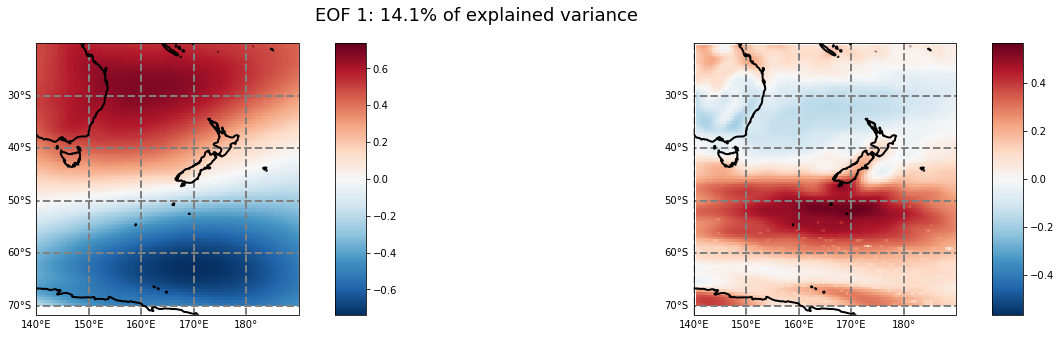

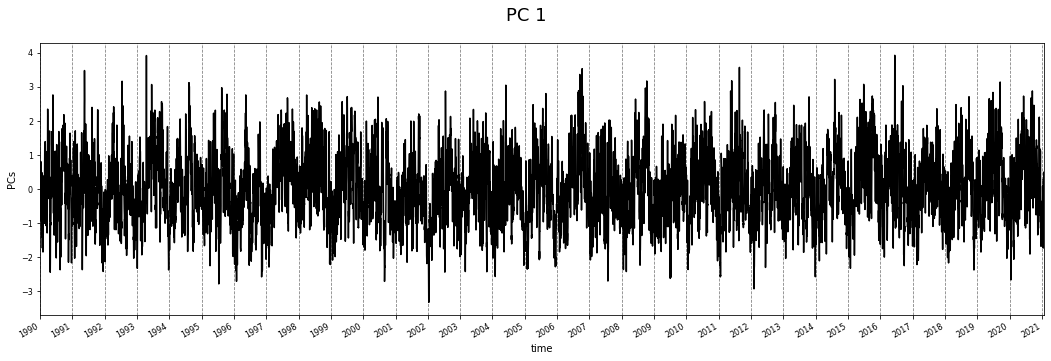

In [3]:
# load / calculate the regional pcs
if os.path.isfile('../data/cfsr/cfsr_regional_daily_pcs.nc'):
    import xarray as xr
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_daily_pcs.nc'
    )
    from sscode.plotting.pca import plot_pcs
    plot_pcs(pcs_cfsr,n_plot=1)

### Plot mean SLP and SS circumstances

As we are trying to represent all the different climate situations, we will now plot how the mean SLP and SS circumstances might look like in the area around New Zealand.


 loading the Moana v2 hindcast data (ss)... 


 loading the DAC hindcast data... 



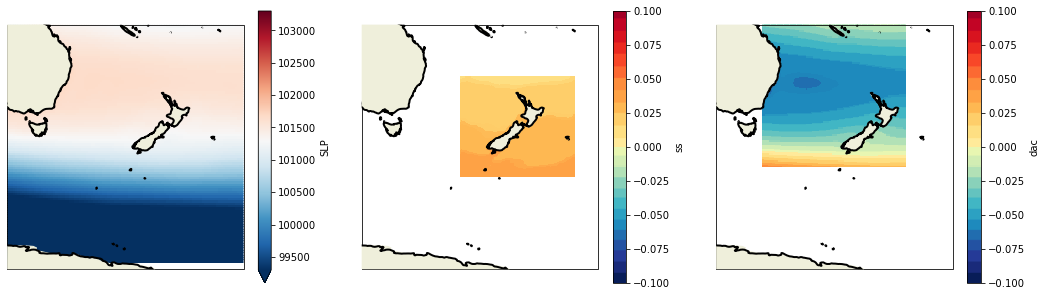

In [4]:
# plot the mean SLP and SS situations
fig, axes = plt.subplots(ncols=3,figsize=_figsize,
    subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}
)
load_cfsr_moana_uhslc.predictor_slp.mean(dim='time').plot(
    ax=axes[0],cmap='RdBu_r',vmin=101300-2000,vmax=101300+2000,
    transform=ccrs.PlateCarree()
)
load_moana_hindcast_ss(daily=True).mean(dim='time').plot(
    ax=axes[1],cmap=custom_cmap(15,'YlOrRd',0.15,0.9,'YlGnBu_r',0,0.85),
    vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree()
)
load_dac_hindcast().mean(dim='time').plot(
    ax=axes[2],cmap=custom_cmap(15,'YlOrRd',0.15,0.9,'YlGnBu_r',0,0.85),
    vmin=-0.1,vmax=0.1,transform=ccrs.PlateCarree()
)
plot_ccrs_nz(axes,plot_labels=(False,None,None),plot_region=(True,default_region))

## Calculate the weather types

add extra info regarding weather types!!

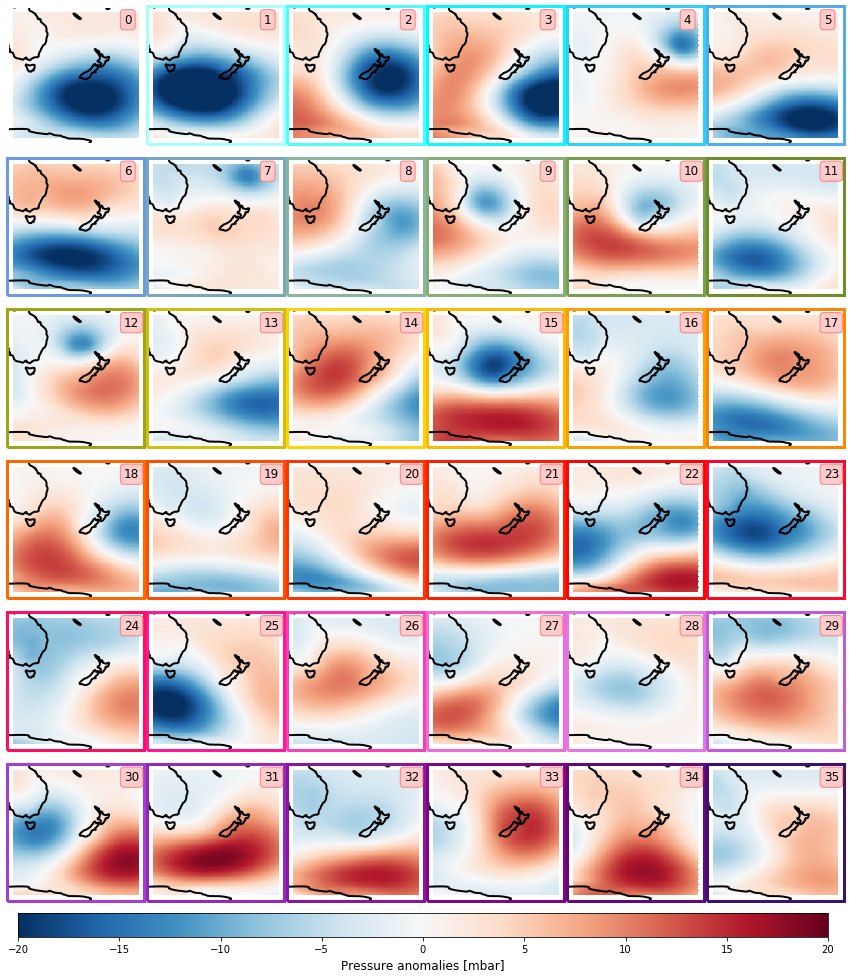

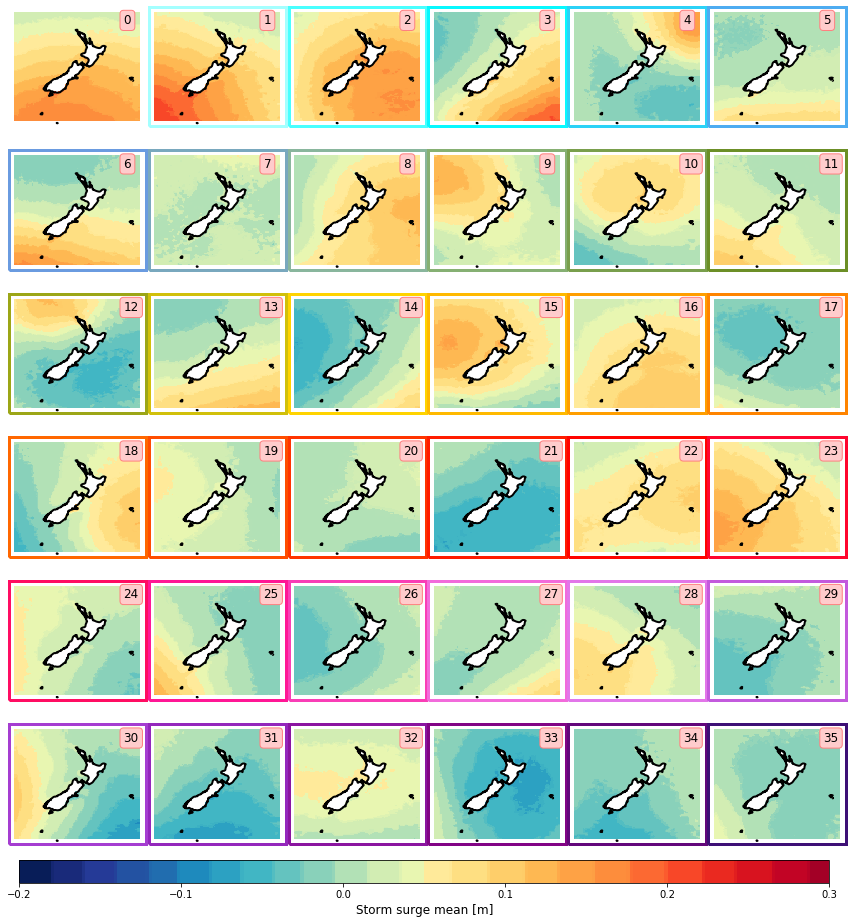

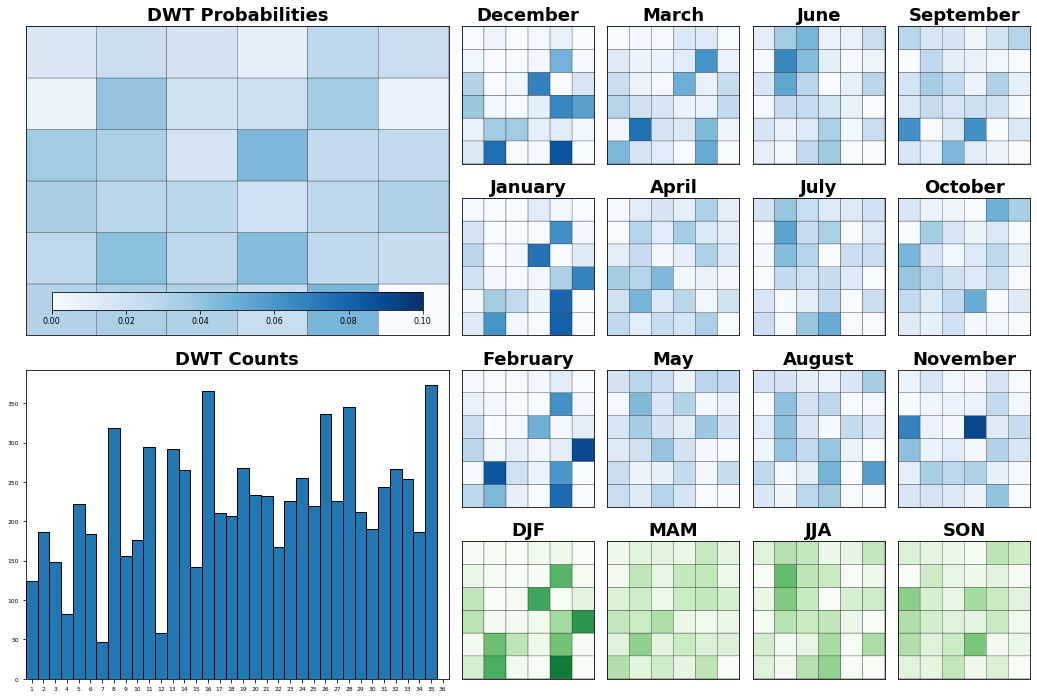

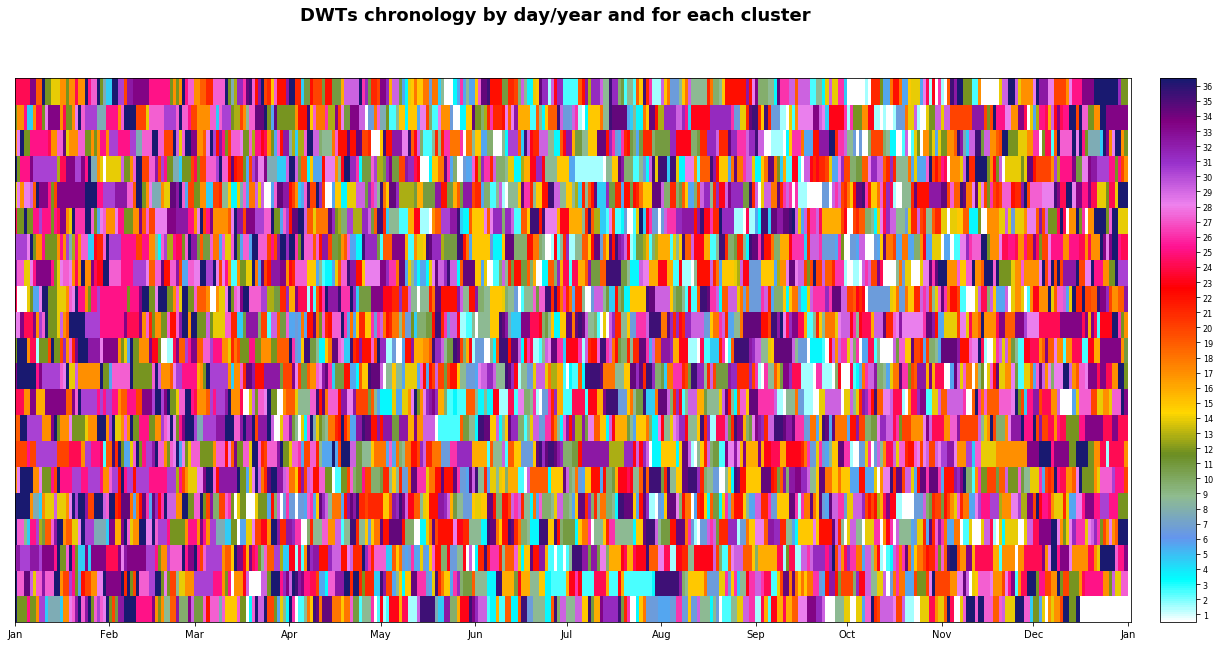

In [5]:
# lets calculate the weather types
run = False
if run:
    kms_data = KMA_simple(
        load_cfsr_moana_uhslc.predictor_slp,
        load_moana_hindcast_ss(daily=True),
        pcs_cfsr, n_clusters=81, calculate_gev_stats=False
    )
    # kms_data[0].to_netcdf('../data/statistics/kms_36_data_shore.nc'), \
    #     kms_data[1].to_netcdf('../data/statistics/gev_clusters36_mle_shore.nc')
else:
    import xarray as xr
    kms_data = [
        xr.open_dataset('../data/statistics/kms_36_data_shore.nc'),
        xr.open_dataset('../data/statistics/gev_clusters36_mle_shore.nc')
    ]
    from sscode.plotting.kma import Plot_DWTs_Mean_Anom, Plot_DWTs_Probs, Chrono_dwts_hist
    cmap_models = Plot_DWTs_Mean_Anom(
        kms_data[0],gev_data=kms_data[1]
    )
    Plot_DWTs_Probs(
        kms_data[0].sorted_bmus,36
    )
    Chrono_dwts_hist(
        kms_data[0]
    )

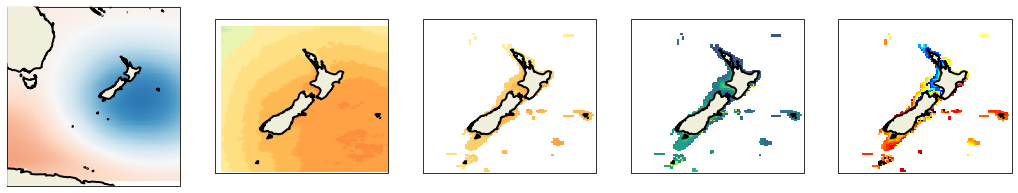

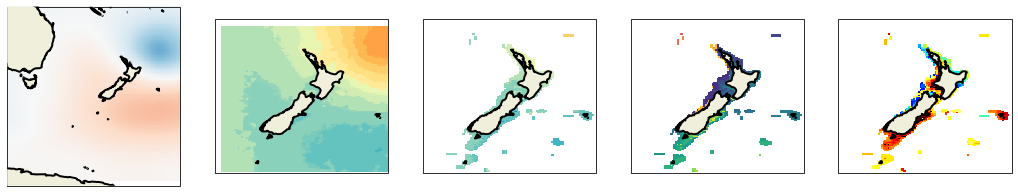

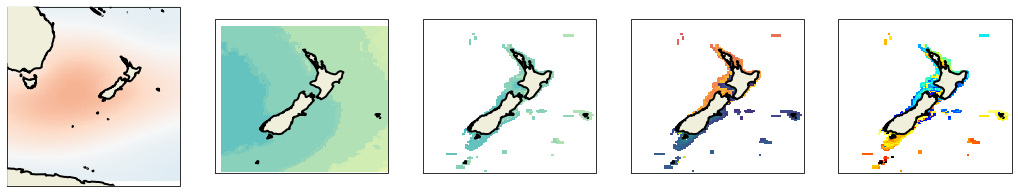

In [6]:
from sscode.plotting.kma import plot_cluster_wgev
plot_cluster_wgev(kms_data[0],kms_data[1],[2,4,26])

In [7]:
import plotly.io as pio
pio.renderers.default = 'notebook'
# plot PCs-bmus relations
px.scatter_3d(
    pd.DataFrame({
        'PC1':pcs_cfsr.PCs.sel(time=kms_data[0].train_time,n_components=0).values,
        'PC2':pcs_cfsr.PCs.sel(time=kms_data[0].train_time,n_components=1).values,
        'PC3':pcs_cfsr.PCs.sel(time=kms_data[0].train_time,n_components=2).values,
        'sorted_bmus':kms_data[0].sorted_bmus.values
    }),x='PC1',y='PC2',z='PC3',color='sorted_bmus',
    color_continuous_scale=px.colors.sequential.Jet
    # ['yellow','lime','green','lightblue','blue','purple','pink','grey','black']
)

```{tip}
Images generated by code, as the one above, can be easily open in a new window, as they have all been generated with good quality for this particular purpose!!
```

## Extras..

### Calculate prediction errors (not the goal)


 loading the Moana v2 hindcast data (ss)... 



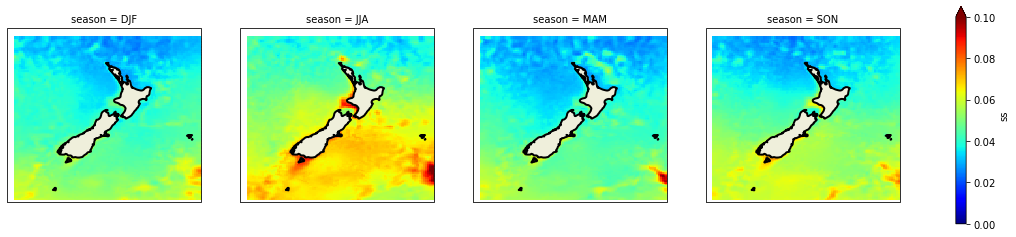

In [8]:
# check predictions with the kmeans_algo==weather_types
p = np.abs(load_moana_hindcast_ss(daily=True).sel(time=kms_data[0].test_time) - \
        kms_data[0].ss_clusters_mean.sel(n_clusters=kms_data[0].bmus_pred.values).values)\
        .groupby('time.season').mean().plot(
            col='season',vmin=0.0,vmax=0.1,cmap='jet',figsize=(20,4),
            subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
            transform=ccrs.PlateCarree()
    )
plot_ccrs_nz(p.axes.flatten(),plot_labels=(False,None,None))

### Perform analysis in south-west coast

here goes extra info for the GEV...

(<Figure size 768x474.66 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f31dec6e198>)

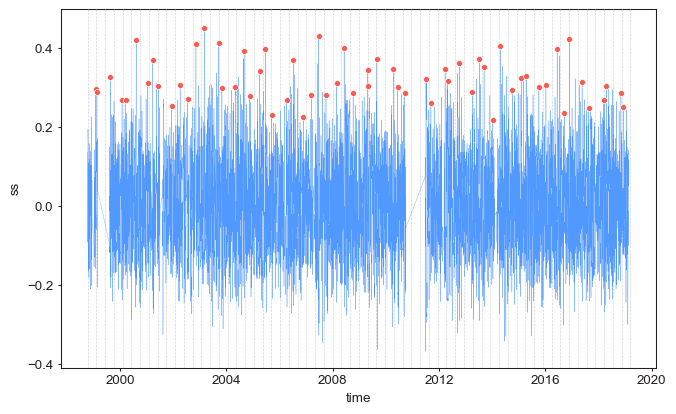

In [9]:
# perform pyextremes with tg data
from pyextremes import EVA

model = EVA(
    data=load_cfsr_moana_uhslc.validator.sel(name='a_Bluff').ss.dropna(dim='time')\
        .to_dataframe()['ss']
)
model.get_extremes(
    method='BM',extremes_type='high',
    block_size='120.2425D',errors='ignore'
)
model.plot_extremes()

In [10]:
model.fit_model(model='Emcee')

In [11]:
# have a look
model

                                  Univariate Extreme Value Analysis                                  
                                            Original Data                                            
-----------------------------------------------------------------------------------------------------
Data label:                                  ss      Data range:        October 1998 to February 2019
                                           Extreme Values                                            
-----------------------------------------------------------------------------------------------------
Number of extreme events:                    61      Extraction method:                            BM
Type of extreme events:                    high      Block size:                    120 days 05:49:12
                                                Model                                                
----------------------------------------------------------------------------------

((<Figure size 768x768 with 6 Axes>,
  [[<matplotlib.axes._subplots.AxesSubplot at 0x7f31de6a64e0>,
    <matplotlib.axes._subplots.AxesSubplot at 0x7f31de613ef0>]]),
 (<Figure size 768x576 with 3 Axes>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f31de5b5e10>]))

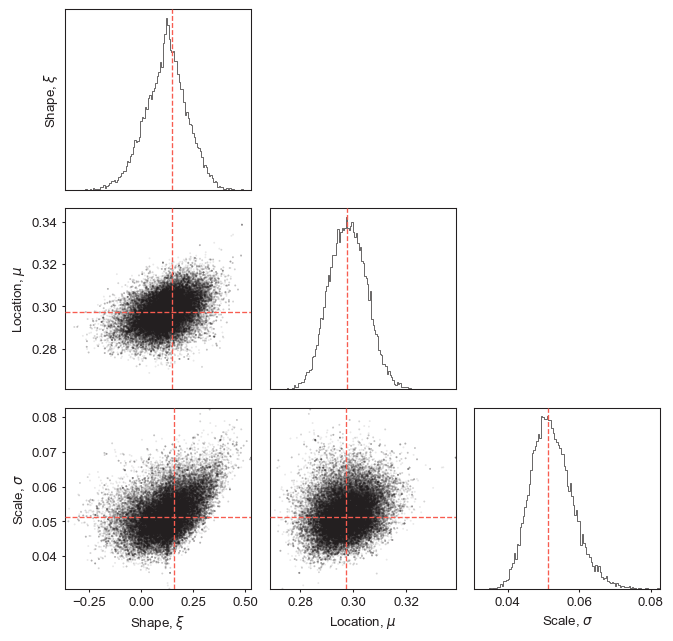

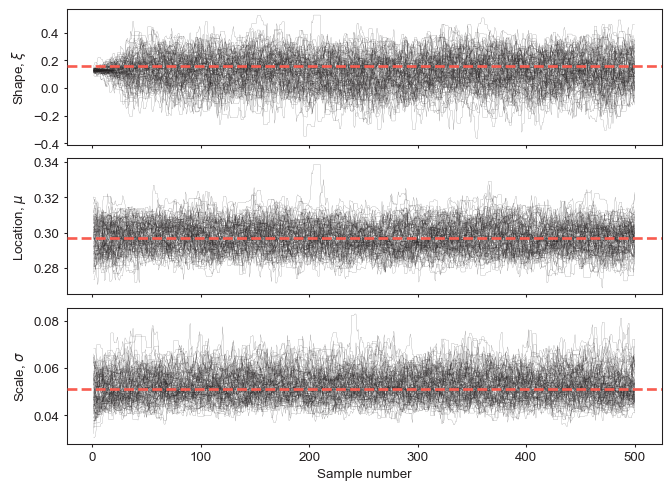

In [12]:
model.plot_corner(), model.plot_trace()

(<Figure size 768x768 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f31e1884080>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f31e19c20f0>))

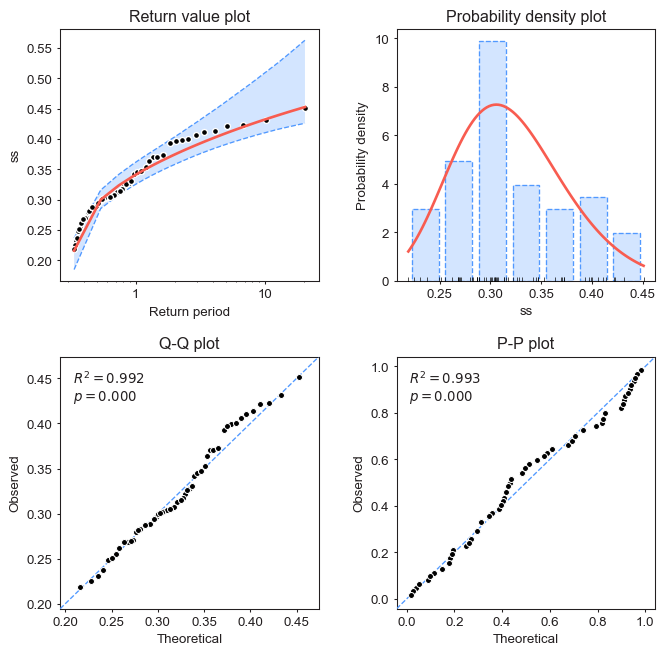

In [13]:
model.plot_diagnostic(burn_in=0)

In [14]:
print('Free parameters {} \n Log-likelihood: {} \n AIC {}'.format(
    model.distribution.mle_parameters, model.model.loglikelihood, model.model.AIC
))

Free parameters {'c': 0.12685681034201807, 'loc': 0.29739260863036815, 'scale': 0.04968738900158581} 
 Log-likelihood: 90.70994334701814 
 AIC -174.99883406245732
